<a href="https://colab.research.google.com/github/abdullahamruf/Skin_Cancer/blob/main/skin_isic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import system libs
import os
import time
import shutil
import itertools
import joblib

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import glob as gb

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Rescaling, RandomZoom, RandomFlip, RandomRotation
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler


from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/skin_isic_2018/skintrain'
test_dir = '/content/drive/MyDrive/skin_isic_2018/skintest'
valid_dir = '/content/drive/MyDrive/skin_isic_2018/skinvalid'
IMG_SIZE = (299, 299) # resolution
BATCH_SIZE = 128
# Create TensorFlow datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42,
    label_mode='categorical'
)

valid_dataset = image_dataset_from_directory(
    valid_dir,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42,
    label_mode='categorical'
)

Found 6618 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 2144 files belonging to 2 classes.


In [ ]:
normalization_layer = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

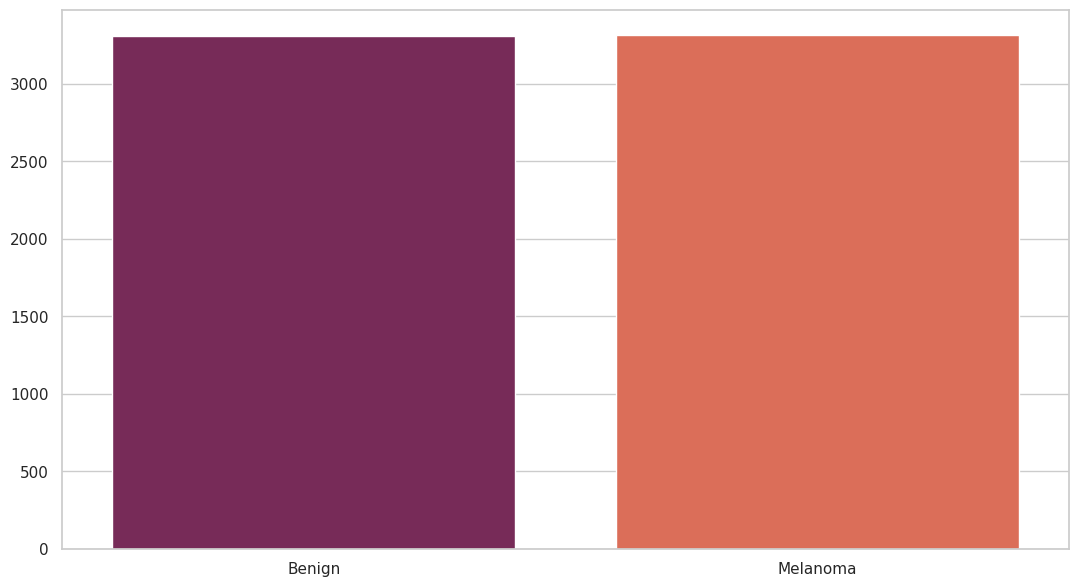

In [ ]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(train_dir):
    files = gb.glob(pathname=str(train_dir + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=["Benign", "Melanoma"], y=Data_imbalance, palette="rocket")
plt.show()

In [ ]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 2.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.00


In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[299, 299, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal' ))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=2, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 149, 149, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 149, 149, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 64)        0

In [ ]:
history = model.fit(train_dataset,
                    epochs=25,
                    batch_size=BATCH_SIZE,
                    validation_data=(valid_dataset) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
52/52 [==============================] - 166s 2s/step - loss: 1.2231 - accuracy: 0.6552 - val_loss: 1.3359 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 2/25
52/52 [==============================] - 67s 1s/step - loss: 1.0347 - accuracy: 0.7392 - val_loss: 1.2451 - val_accuracy: 0.4981 - lr: 0.0010
Epoch 3/25
52/52 [==============================] - ETA: 0s - loss: 0.8973 - accuracy: 0.7915
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
52/52 [==============================] - 68s 1s/step - loss: 0.8973 - accuracy: 0.7915 - val_loss: 1.3148 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 4/25
52/52 [==============================] - 73s 1s/step - loss: 0.7948 - accuracy: 0.8302 - val_loss: 1.1789 - val_accuracy: 0.5345 - lr: 5.0000e-04
Epoch 5/25
52/52 [==============================] - 66s 1s/step - loss: 0.7291 - accuracy: 0.8546 - val_loss: 1.1583 - val_accuracy: 0.5700 - lr: 5.0000e-04
Epoch 6/25
52/52 [==============================] - 73s 1s/step - l

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

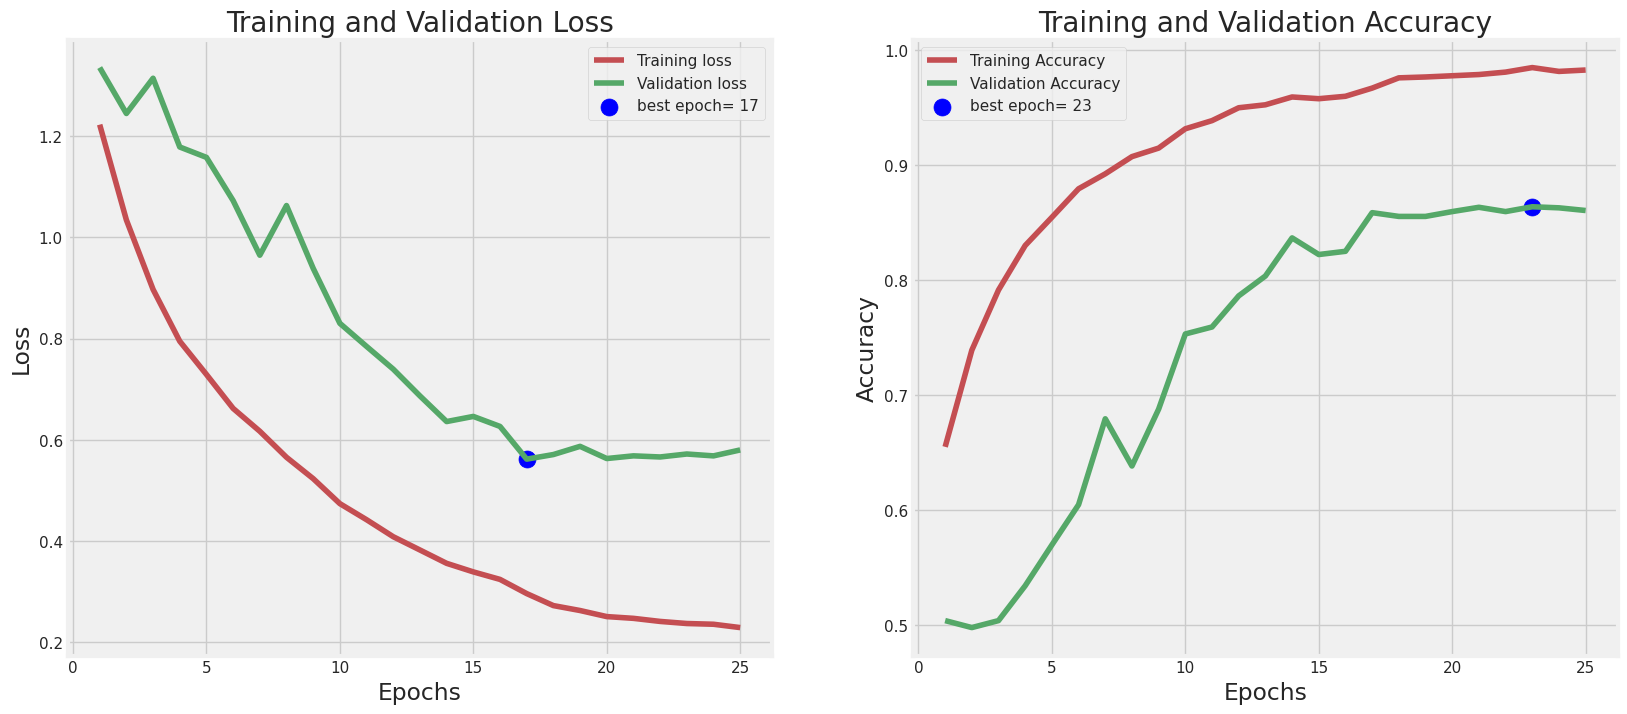

In [ ]:
plot_training(history)

In [ ]:
train_score = model.evaluate(train_dataset, verbose= 1)
test_score = model.evaluate(test_dataset, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 12s 3s/step - loss: 0.2723 - accuracy: 0.9640
Train Loss:  0.20859861373901367
Train Accuracy:  0.988062858581543
--------------------
Test Loss:  0.2723412811756134
Test Accuracy:  0.9639999866485596


In [ ]:
model.save('/content/drive/MyDrive/skin_isic_2018/my_model_isic_tt.h5')

In [ ]:
from tensorflow import keras
from keras.models import load_model

In [ ]:
cnn_model = load_model('/content/drive/MyDrive/skin_isic_2018/my_model_isic_tt.h5')

In [ ]:
import joblib

In [ ]:
joblib.dump(cnn_model, '/content/drive/MyDrive/skin_isic_2018/cnn_model_skin_isic_tt.joblib')

['/content/drive/MyDrive/skin_isic_2018/cnn_model_skin_isic_tt.joblib']

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
loaded_cnn_model = joblib.load('/content/drive/MyDrive/skin_isic_2018/cnn_model_skin_isic_tt.joblib')

In [ ]:
train_dir = '/content/drive/MyDrive/skin_isic_2018/skintrain'
test_dir = '/content/drive/MyDrive/skin_isic_2018/skintest'
IMG_SIZE = (299, 299) # resolution
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)
test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

Found 6618 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
normalization_layer = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
def extract_images_and_labels(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.extend(image_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(images), np.array(labels)
train_images, train_labels = extract_images_and_labels(train_dataset)
test_images, test_labels = extract_images_and_labels(test_dataset)

In [ ]:
np.save('/content/drive/MyDrive/skin_isic_2018/train_test_arr/train_images.npy', train_images)
np.save('/content/drive/MyDrive/skin_isic_2018/train_test_arr/train_labels.npy', train_labels)
np.save('/content/drive/MyDrive/skin_isic_2018/train_test_arr/test_images.npy', test_images)
np.save('/content/drive/MyDrive/skin_isic_2018/train_test_arr/test_labels.npy', test_labels)

In [ ]:
X_train_features = loaded_cnn_model.predict(train_images)
X_test_features = loaded_cnn_model.predict(test_images)

16/16 [==============================] - 3s 193ms/step


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_features, train_labels)

RandomForestClassifier(random_state=0)

In [ ]:
# Make predictions using the trained Random Forest classifier
prediction = rf_classifier.predict(X_test_features)

In [ ]:
print(prediction.shape, test_labels.shape)

(500,) (500,)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
accuracy = accuracy_score(test_labels, prediction)
report = classification_report(test_labels, prediction)

In [ ]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.968
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       250
           1       0.96      0.97      0.97       250

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



In [ ]:
classes = {0: ('Benign'),
           1: ('Melanoma')}

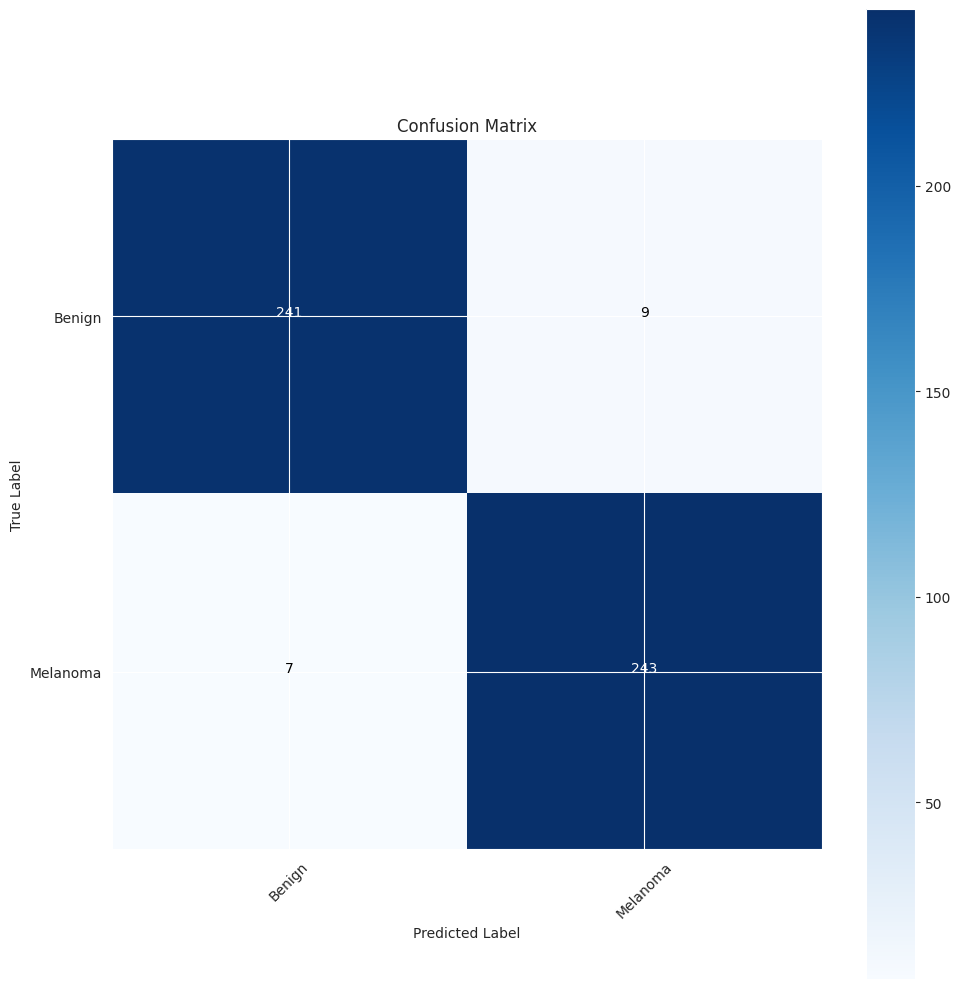

In [ ]:
# Confusion matrix
cm = cm = confusion_matrix(test_labels, prediction)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Define the class names based on your classes dictionary
class_names = [classes[key] for key in sorted(classes.keys())]

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

mcc = matthews_corrcoef(test_labels, prediction)
kappa = cohen_kappa_score(test_labels, prediction)

print("Matthews Correlation Coefficient:", mcc)
print("Cohen's Kappa:", kappa)

Matthews Correlation Coefficient: 0.9360299534377726
Cohen's Kappa: 0.9359999999999999


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
class_keys_array = list(classes.keys())
class_keys_array

[0, 1]

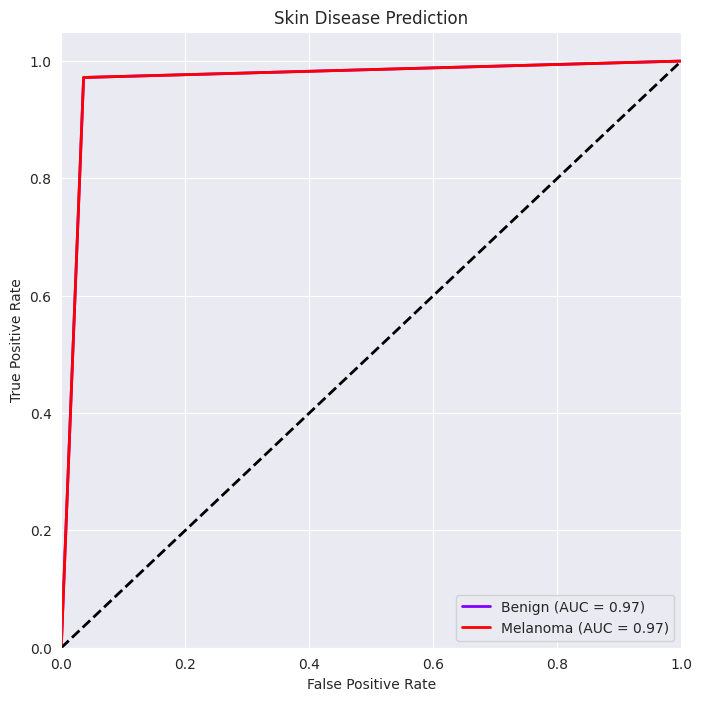

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_keys_array)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, prediction)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))
colors = iter(plt.cm.rainbow(np.linspace(0, 1,len(class_keys_array))))
for i, color in zip(range(len(class_keys_array)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'
             ''.format(classes[class_keys_array[i]], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Skin Disease Prediction')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute ROC curve and ROC AUC score for class 1 test_labels, prediction
fpr_class1, tpr_class1, _ = roc_curve(test_labels, prediction, pos_label=1)
roc_auc_class1 = roc_auc_score(test_labels, prediction)

# Compute ROC curve and ROC AUC score for class 0
fpr_class0, tpr_class0, _ = roc_curve(test_labels, prediction, pos_label=0)
roc_auc_class0 = roc_auc_score(test_labels, prediction)

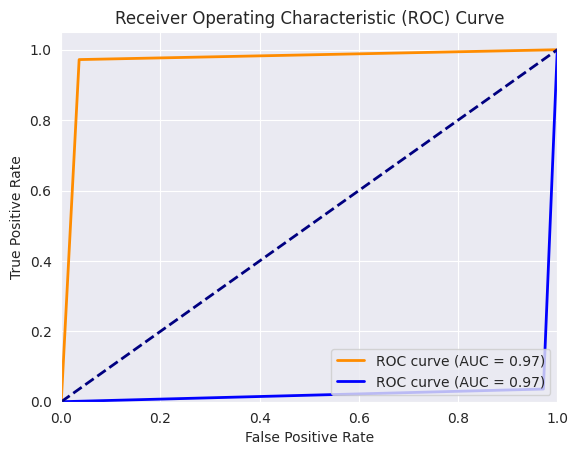

In [ ]:
# Plot ROC curve for class 1
plt.plot(fpr_class1, tpr_class1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_class1)

# Plot ROC curve for class 0
plt.plot(fpr_class0, tpr_class0, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_class0)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()